# EnerjiSA Enerji Veri Maratonu | TRAI x Coderspace

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import random

import warnings
warnings.filterwarnings('ignore')

# 1. KEŞİFSEL VERİ ANALİZİ 

Bu projedeki amaç, lisanssız güneş enerjisi santrallerinin üretim miktarlarını saatlik bazda tahmin edilmesidir. Öncelikle Veri Keşfi yapılacaktır.

Tahmin edilmesi istenen tarih aralığı: `01.12.2021 – 31.12.2021` 

## 1.1. Veriyi Okuma 

Bu kısımda veri seti üzerinde genel bir fikir kazanmak adına inceleme yapıldı:
- 2 veriseti **merge()** fonksiyonu ile 'DateTime' kolonuna göre birleştirildi. Daha sonra **concat()** fonksiyonu ile birleştirmenin daha uygun görüldü ve concat() fonksiyonu ile birleştirildi.
- Veri setinin ilk 5 satırı yazdırıldı.
- Veri setinin kolonlarının isimleri, kolonların veri tipleri ve içerisindeki dolu veri sayısı yazdırıldı.

In [2]:
# verinin okunması
# csv okuma

data_temperature = pd.read_csv("temperature.csv", sep = ";", decimal = ",")
data_generation = pd.read_csv("generation.csv", sep = ";", decimal = ",")

In [ ]:
# merge() fonksiyonu birleştirmenin hangi değişkene göre yapılacağını kendi anlar, özellikle belirtilebilir de.
# 'DateTime' kolonuna göre birleştirmesi belirtildi.

# data = pd.merge(data_temperature, data_generation, on = "DateTime")
# df = data.copy()

In [3]:
# iki dataframe'i yan yana (axis = 1) birleştirmek için concat() kullanıldı.

data = pd.concat([data_temperature, data_generation.drop('DateTime', axis = 1)], axis = 1)
df = data.copy()

In [4]:
# verinin ilk 5 satırını gösterir.

df.head()

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation
0,01Jan2019 0:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0.000000
1,01Jan2019 1:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,0.000000
2,01Jan2019 2:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,0.000008
3,01Jan2019 3:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,0.000000
4,01Jan2019 4:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,0.000008


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26399 entries, 0 to 26398
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DateTime             26304 non-null  object 
 1   AirTemperature       26304 non-null  float64
 2   ComfortTemperature   26304 non-null  float64
 3   RelativeHumidity     26304 non-null  float64
 4   WindSpeed            26304 non-null  float64
 5   WindDirection        26304 non-null  float64
 6   WWCode               20050 non-null  float64
 7   EffectiveCloudCover  26304 non-null  float64
 8   Generation           25560 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.8+ MB


Veri setinin genel bilgileri yazdırıldığında kayıp(null) değerler olduğu görülmektedir.

- `DateTime`: Sıcaklık değişkenlerinin gözlemlendiği, üretimin yapıldığı saat aralığını tarih-saat formatında belirtir.

   * **datetime**


- `AirTemperature`: Saat aralığındaki hava sıcaklığını **Celsius** biriminde belirtir.

   * **numerical-interval**, literatürde natural zero start point’i yoktur.


- `ComfortTemperature`: Saat aralığındaki hissedilen hava sıcaklığını **Celsius** biriminde belirtir.

    * **numerical-interval**, natural zero start point’i yoktur.


- `RelativeHumidity`: Saat aralığındaki nem oranını belirtir.

    * **numerical-ratio**, natural true zero point’i vardır.


- `WindSpeed`: Saat aralığındaki rüzgar hızını km/s biriminde belirtir.

    * **numerical-ratio**, natural true zero point’i vardır.


- `WindDirection`: Saat aralığındaki rüzgar yönünü belirtir.

    * **categorical-nominal** *????*


- `WWCode`: Saat aralığındaki hava durumu kodunu belirtir.

    * **categorical-nominal**


- `EffectiveCloudCover`: Saat aralığındaki bulutluluk oranını sekizlik ölçü birimi cinsinden belirtir.

    * **ratio**, natural true zero point’i vardır.

 
- `Generation`: İlgili saat aralığında yapılan toplam üretimi MWh biriminde belirtir.

    * **ratio**, natural true zero point’i vardır.

## 1.2. Missing Value Keşfi ve Temizlenmesi / Doldurulması

Bu aşamada genel olarak veri seti üzerindeki eksik verilerin temizlenmesi ve düzeltilmesi üzerine çalışıldı.

- Null veriler tespit edilerek toplam sayıları ve bu sayılara oranla yüzdeleri yazdırıldı. 
- Bütün değerleri eksik olan gözlem birimleri silindi.
- **WWCode**'daki eksik değerleri 9999 ile doldurma işlemi gerçekleştirildi.

In [6]:
# yüzdesel olarak eksik verilerin kontrolü : 

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(9)

,Total,Percent
WWCode,6349,0.240502
Generation,839,0.031782
EffectiveCloudCover,95,0.003599
WindDirection,95,0.003599
WindSpeed,95,0.003599
RelativeHumidity,95,0.003599
ComfortTemperature,95,0.003599
AirTemperature,95,0.003599
DateTime,95,0.003599


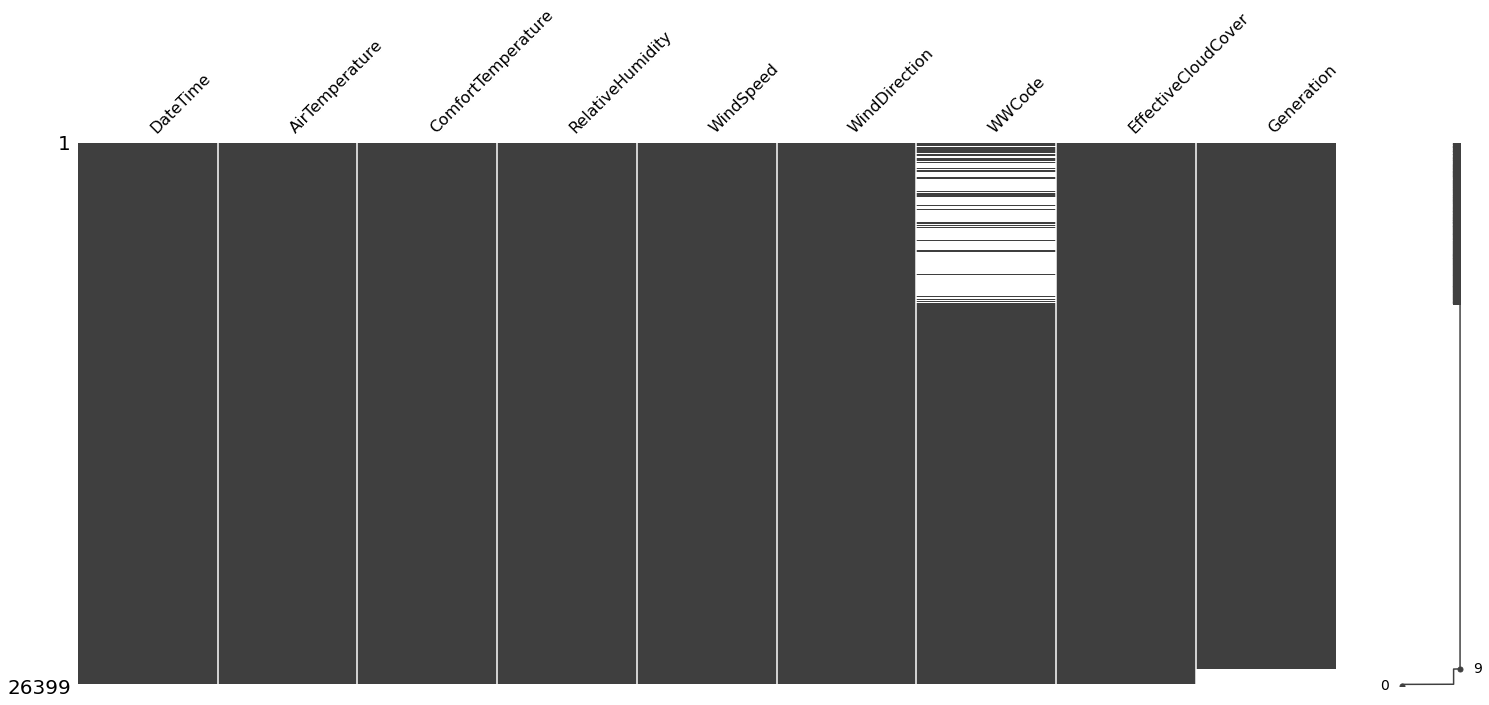

In [7]:
msno.matrix(df);

Bu bilgiler ışığında;
- **WWCode**'daki kolonundaki null değeri diğer kolonlara göre çok yüksek çıkmıştır.

In [8]:
# bütün değerleri eksik olan gözlem birimleri

df[df.isnull().all(axis=1)]

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation
26304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Bütün değerleri eksik olan 95 tane gözlem biriminin buluduğu gözlemlendi ve silme işlemi gerçekleştirildi.

In [9]:
# bütün değerleri eksik olan gözlem birimlerini silme

df.dropna(how = "all", inplace = True)   

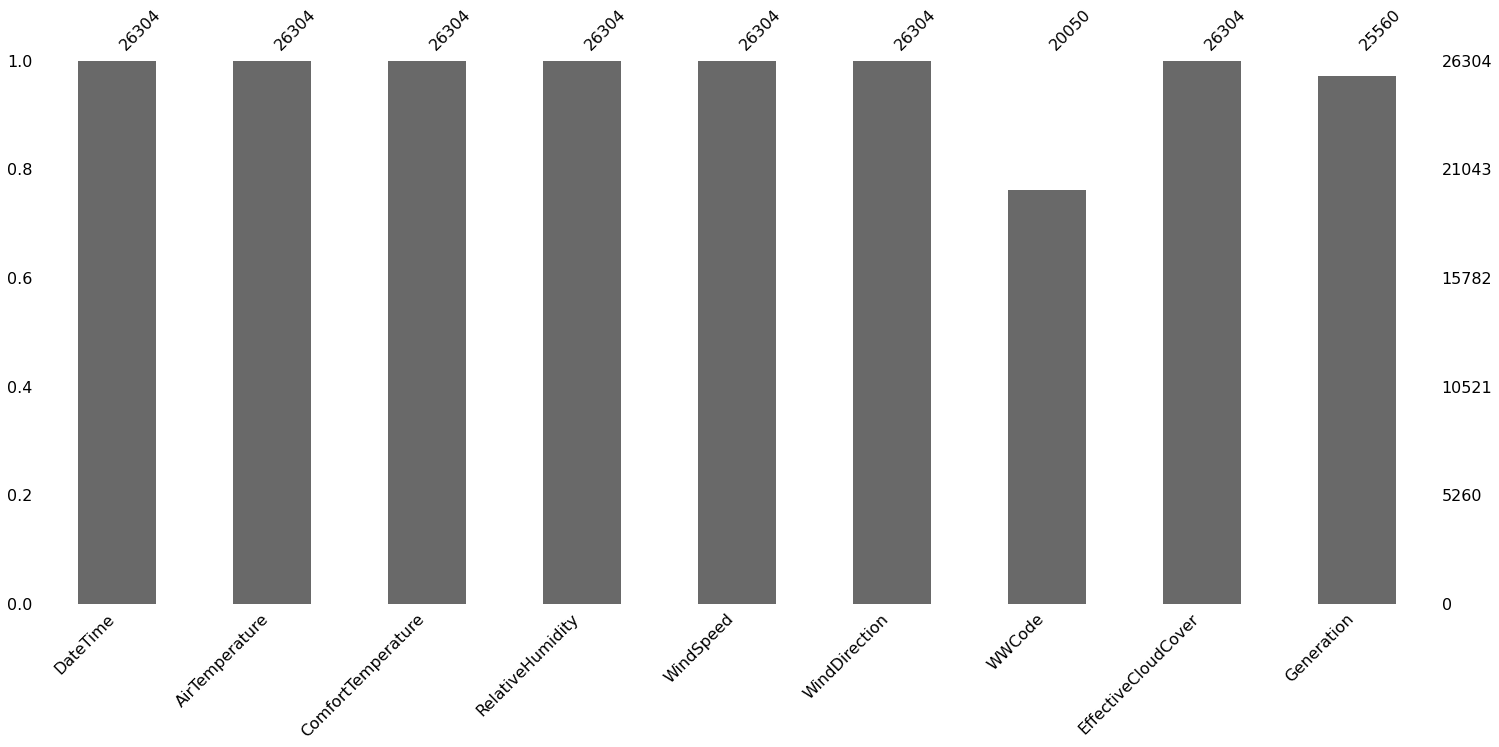

In [10]:
msno.bar(df);

In [11]:
# WWCode'daki eksik değerler 9999 ile doldurur. (gözlemlemek için)

df['WWCode'] = df['WWCode'].fillna(9999)

In [ ]:
# WWCode'daki eksik değerler median ile doldurur. (gözlemlemek için)

df['WWCode'] = df['WWCode'].fillna(df['WWCode'].median())

- Belirtilen eksik gözlem birimleri silindikten ve doldurma işlemi gerçekleştirildikten sonra kalan null veriler tekrar yazdırıldı.

In [12]:
# tüm değişkenlerdeki toplam eksik değer sayısı

df.isnull().sum()  

DateTime                 0
AirTemperature           0
ComfortTemperature       0
RelativeHumidity         0
WindSpeed                0
WindDirection            0
WWCode                   0
EffectiveCloudCover      0
Generation             744
dtype: int64

In [13]:
# gözlem ve değişken sayısı
# veriseti, 25560+744 gözlem birimi ve 9 değişkenden oluşuyor.

df.shape   

(26304, 9)

In [14]:
# kolonlardaki 0'ların yüzdesel olarak gösterimi: 

total = (df == 0).sum(axis=0).sort_values(ascending=False)
percent = ((df == 0).sum(axis=0)/df.count()).sort_values(ascending=False)
zeros = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
zeros.head(8)

,Total,Percent
EffectiveCloudCover,10130,0.385113
Generation,6449,0.252308
WWCode,6294,0.239279
WindDirection,2577,0.097970
WindSpeed,2577,0.097970
AirTemperature,117,0.004448
ComfortTemperature,101,0.003840
RelativeHumidity,0,0.000000


In [15]:
# sütunlardaki unique değerlerin sayısının yazdırılması

for col in df.columns:
        print(str(col) +" : " + str(df[col].nunique()))

DateTime : 26304
AirTemperature : 494
ComfortTemperature : 502
RelativeHumidity : 849
WindSpeed : 78
WindDirection : 267
WWCode : 55
EffectiveCloudCover : 78
Generation : 16031


## 1.3. Değişken Tip Dönüşümleri

- Kolonları inceleme aşamasında içerisinde kategorik (object) değerler bulunan bazı değişkenlerin aslında nümerik ve tarih tipinde değişken olduğu fark edildi ve tip dönüşümü gerçekleştirildi.

In [16]:
# tarih veri içerip object gözüken değişkenin tipinin datetime tipine çevrilmesi :

df.DateTime = pd.to_datetime(df.DateTime)

# sayısal veri içerdikleri için object gözüken değişkenlerin tipinin float64 tipine çevrilmesi : 

# for col in ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 'EffectiveCloudCover', 'Generation']:
#     df[col] = df[col].str.replace(',', '.').astype(float)
    
# 'WindDirection' ve 'WWCode'ı float'tan category'ye dönüştürme

# df = df.astype({'WindDirection':'int', 'WWCode':'int'}) 
# df = df.astype({'WindDirection':'object', 'WWCode':'object'})  

In [17]:
# değişkenler ve tipleri

df.dtypes   

DateTime               datetime64[ns]
AirTemperature                float64
ComfortTemperature            float64
RelativeHumidity              float64
WindSpeed                     float64
WindDirection                 float64
WWCode                        float64
EffectiveCloudCover           float64
Generation                    float64
dtype: object

In [18]:
num_cols = list(df.select_dtypes(include = ['float64']))
print(f"Nümerik kolonların toplam sayısı: {len(num_cols)}")

cat_cols = list(df.select_dtypes(include = ['object']))
print(f"Kategorik kolonların toplam sayısı: {len(cat_cols)}")

date_cols = list(df.select_dtypes(include = ['datetime']))
print(f"Datetime kolonların toplam sayısı: {len(date_cols)}")

print(f"Toplam kolon sayısı: {len(num_cols + cat_cols + date_cols)}")

Nümerik kolonların toplam sayısı: 8
Kategorik kolonların toplam sayısı: 0
Datetime kolonların toplam sayısı: 1
Toplam kolon sayısı: 9


In [19]:
# veriseti içerisindeki tüm değişkenler için temel betimsel ve dağılım istatikleri ortaya koyar. 
# eksik gözlemleri göz ardı eder ve kategorik değişkenleri dışarıda bırakır.
# bütün değişkenler sayısal değişkenlerdir.
# .T, transpose alır.

df.describe().T

,count,mean,std,min,25%,50%,75%,max
AirTemperature,26304.0,13.741522,9.379876,-13.1,6.0,13.400000,21.000000,39.000000
ComfortTemperature,26304.0,13.239397,9.767058,-19.3,5.1,13.000000,21.200000,37.200000
RelativeHumidity,26304.0,54.352832,22.566688,1.6,36.6,55.100000,72.500000,100.000000
WindSpeed,26304.0,1.655931,1.353196,0.0,0.5,1.500000,2.600000,13.400000
WindDirection,26304.0,87.463960,100.762932,0.0,20.0,30.000000,170.000000,360.000000
WWCode,26304.0,2387.329494,4251.238500,0.0,1.0,5.000000,95.000000,9999.000000
EffectiveCloudCover,26304.0,2.614051,2.497609,0.0,0.0,2.100000,5.000000,8.000000
Generation,25560.0,89.724239,126.180117,0.0,0.0,4.317082,168.498464,456.319322


## 1.4. Gruplama İşlemleri

- *'Generation'* değişkeninin 1'den küçük ve büyük olmasına göre *'WWCode'* değişkeninde gruplama işlemi yapıldı.

In [ ]:
zero = df[(df['Generation'] < 1)]
not_zero = df[(df['Generation'] >= 1)]

WindDirection_ratio = ((zero['WindDirection'].value_counts()) / (zero['WindDirection'].value_counts() + not_zero['WindDirection'].value_counts())).sort_values(ascending=False)
WWCode_ratio = ((zero['WWCode'].value_counts()) / (zero['WWCode'].value_counts() + not_zero['WWCode'].value_counts())).sort_values(ascending=False)

In [ ]:
WindDirection_ratio

In [ ]:
WWCode_ratio

In [ ]:
df = df.astype({'WWCode':'int'}) 
df = df.astype({'WWCode':'object'})

In [20]:
# 'WWCode'ı önce float'tan int'e dönüştürme ve gruplama ile object'e dönüştürme : 

df = df.astype({'WWCode':'int'}) 

df["WWCode"].replace({
    99 : "%100"  , 62 : "%100"  , 63 : "%100"  , 47 : "%100"  ,
    13 : "%80-84", 48 : "%80-84", 8  : "%80-84", 44 : "%80-84",
    41 : "%70-66", 83 : "%70-66", 50 : "%70-66", 81 : "%70-66", 20 : "%70-66", 46 : "%70-66",
    73 : "%61-58", 51 : "%61-58", 60 : "%61-58", 61 : "%61-58", 21 : "%61-58",
    40 : "%55-52", 68 : "%55-52", 0  : "%55-52", 45 : "%55-52", 
    71 : "%50-48", 23 : "%50-48", 43 : "%50-48", 7  : "%50-48", 6  : "%50-48", 10 : "%50-48", 80 : "%50-48", 
    9999: "EKSIK",
    1  : "%46-41", 22 : "%46-41", 70 : "%46-41", 3  : "%46-41",
    26 : "%40-37", 2  : "%40-37", 4  : "%40-37", 5  : "%40-37", 25 : "%40-37", 29 : "%40-37",
    96 : "%33-32", 91 : "%33-32", 77 : "%33-32", 95 : "%33-32",
    85 : "%25-22", 27 : "%25-22", 84 : "%25-22",
    17 : "%17-14", 42 : "%17-14",
    82 : "%0"    , 72 : "%0"    , 86 : "%0"    , 87 : "%0"    , 28 : "%0" }, inplace=True)

df["WWCode"].value_counts()

%55-52    6416
EKSIK     6254
%40-37    5853
%50-48    3319
%46-41    3166
%61-58     701
%33-32     360
%70-66      99
%17-14      54
%25-22      40
%80-84      22
%0          11
%100         9
Name: WWCode, dtype: int64

In [21]:
# df["WWCode"] değişkeninin tipi

df["WWCode"].dtypes  

dtype('O')

In [22]:
# değişkenler ve tipleri

df.dtypes  

DateTime               datetime64[ns]
AirTemperature                float64
ComfortTemperature            float64
RelativeHumidity              float64
WindSpeed                     float64
WindDirection                 float64
WWCode                         object
EffectiveCloudCover           float64
Generation                    float64
dtype: object

## 1.5. Outlier Detection

In [23]:
# Outlier tespiti

num_cols = ['AirTemperature','ComfortTemperature','RelativeHumidity','WindSpeed','WindDirection','EffectiveCloudCover']

for col_name in num_cols :
    
    mean = df[col_name].mean()
    median = df[col_name].median()
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1 #Interquartile range
    lower_bound  = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)][col_name].values
    
    print('\n' + str(col_name) + '\n' +
        '\n' "ortalama   : " + str(mean) +
        '\n' "medyan     : " + str(median) +
        '\n' "Q1 değeri  : " + str(Q1) +
        '\n' "Q3 değeri  : " + str(Q3) + 
        '\n' "IQR değeri : " + str(IQR) + 
        '\n' "alt ve üst değer aralığı  : " + str((lower_bound,upper_bound)) +
        '\n' + str(col_name) + " değişkeninin " + str(len(outliers)) + " outlier noktası vardır." +
        '\n' + str(col_name) + " değişkeninin outlier değerleri: " + str(outliers)
         )
    print('\n\n***********************************************************************************\n')

    # Nümerik column'lardaki outlier değerlerin median değerleri ile değiştirilmesi
        
    df[col_name] = np.where(((df[col_name] > upper_bound) | (df[col_name] < lower_bound)), median, df[col_name])


AirTemperature

ortalama   : 13.741522201946541
medyan     : 13.4
Q1 değeri  : 6.0
Q3 değeri  : 21.0
IQR değeri : 15.0
alt ve üst değer aralığı  : (-16.5, 43.5)
AirTemperature değişkeninin 0 outlier noktası vardır.
AirTemperature değişkeninin outlier değerleri: []


***********************************************************************************


ComfortTemperature

ortalama   : 13.239397049878413
medyan     : 13.0
Q1 değeri  : 5.1
Q3 değeri  : 21.2
IQR değeri : 16.1
alt ve üst değer aralığı  : (-19.050000000000004, 45.35)
ComfortTemperature değişkeninin 1 outlier noktası vardır.
ComfortTemperature değişkeninin outlier değerleri: [-19.3]


***********************************************************************************


RelativeHumidity

ortalama   : 54.352832268856226
medyan     : 55.1
Q1 değeri  : 36.6
Q3 değeri  : 72.5
IQR değeri : 35.9
alt ve üst değer aralığı  : (-17.249999999999993, 126.35)
RelativeHumidity değişkeninin 0 outlier noktası vardır.
RelativeHumidity değişken

In [24]:
num_cols = list(df.select_dtypes(include = ['float64']))
print(f"Nümerik kolonların toplam sayısı: {len(num_cols)}")

Nümerik kolonların toplam sayısı: 7


In [25]:
len(df)

26304

## 1.6. Veriyi Anlama & Görselleştirme

### 1.6.1. Kategorik Değişkenler Özetleri

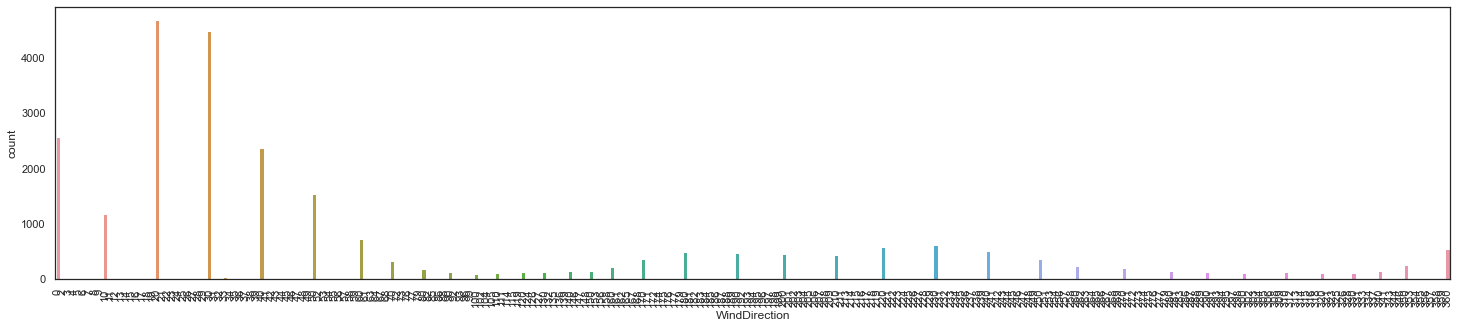

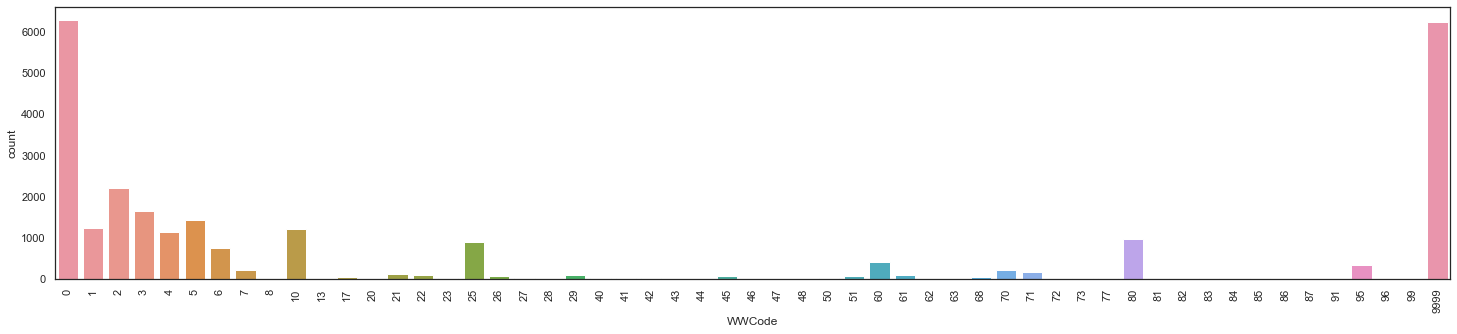

In [143]:
for i in cat_cols:
    plt.figure(figsize=(25,5))
    sns.countplot(x = i, data = df)
    plt.xticks(rotation=90)
    plt.show()

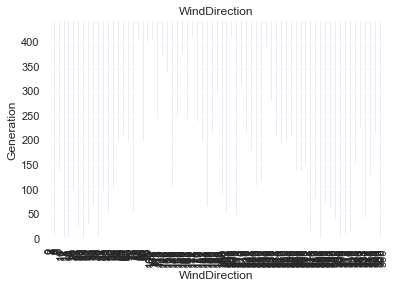

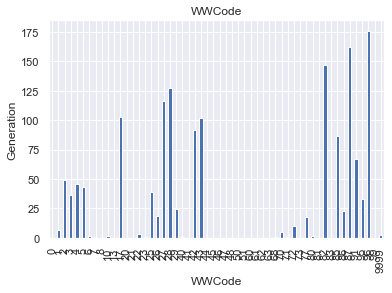

In [274]:
for feature in ["WindDirection", "WWCode"]:
    data = df.copy()
    data.groupby(feature)['Generation'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Generation')
    plt.title(feature)
    plt.show()

### 1.6.2. Sürekli Değişken Özetleri

#### 1.6.2.1. Correlation Heatmap

<AxesSubplot:>

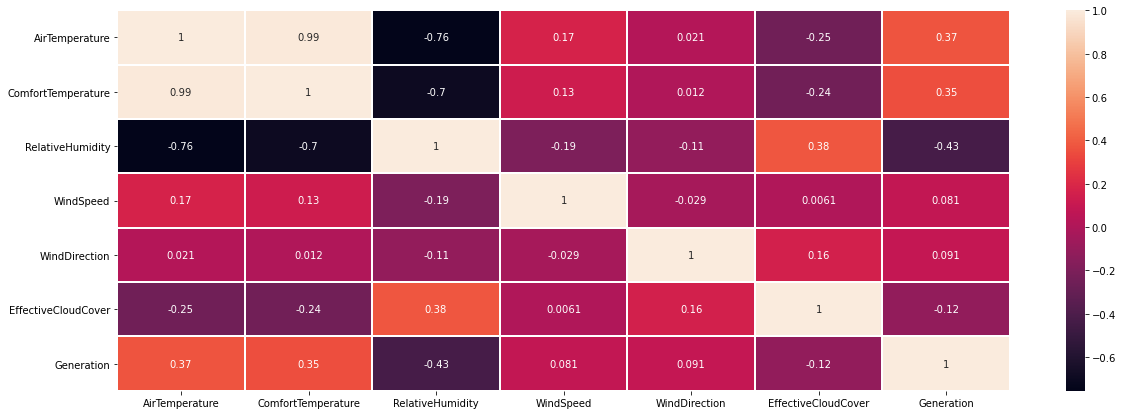

In [26]:
# nümerik değişkenler arasındaki korelasyonlara hızlı bir bakış : 

plt.figure(figsize = (20,7))
sns.heatmap(df.corr(), annot = True, linewidths = 1)

In [27]:
# 'Generation' ile diğer değişkenler arasındaki korelasyonlar :

corr = df.corr()
corr['Generation'].sort_values(ascending = False)

Generation             1.000000
AirTemperature         0.373733
ComfortTemperature     0.354784
WindDirection          0.091261
WindSpeed              0.081379
EffectiveCloudCover   -0.115542
RelativeHumidity      -0.430067
Name: Generation, dtype: float64

#### 1.6.2.2. Histogram ve Yoğunluk Grafikleri

**Histogram** ve **yoğunluk grafikleri**, sayısal değişkenler için kullanılan sayısal değişkenlerin dağılımını ifade etmek için kullanılan veri görselleştirme teknikleridir.

**Histogram**, elimizdeki sayısal sürekli değişkenin dağılımı ile ilgili bilgi verir.

Histogram elimizdeki sayısal değişkenin değerlerini belirli aralıklara böler ve belirli aralıklardaki ilgili değerlerin gözlem ve frekanslarını yansıtır.

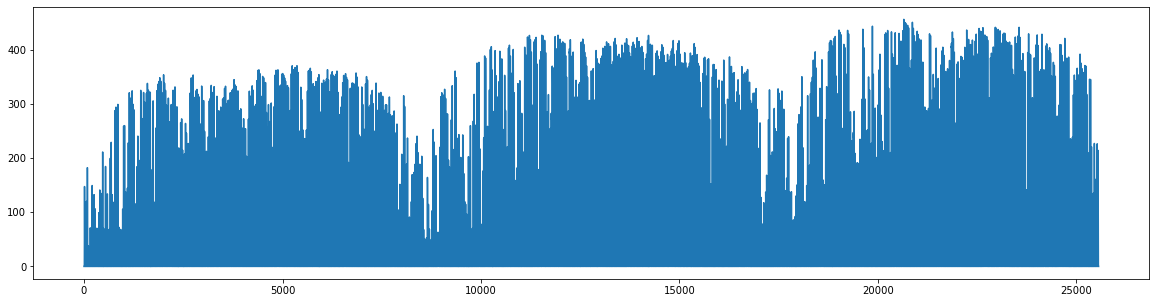

In [28]:
plt.figure(figsize=(20,5))
plt.plot(df['Generation'])
plt.show()

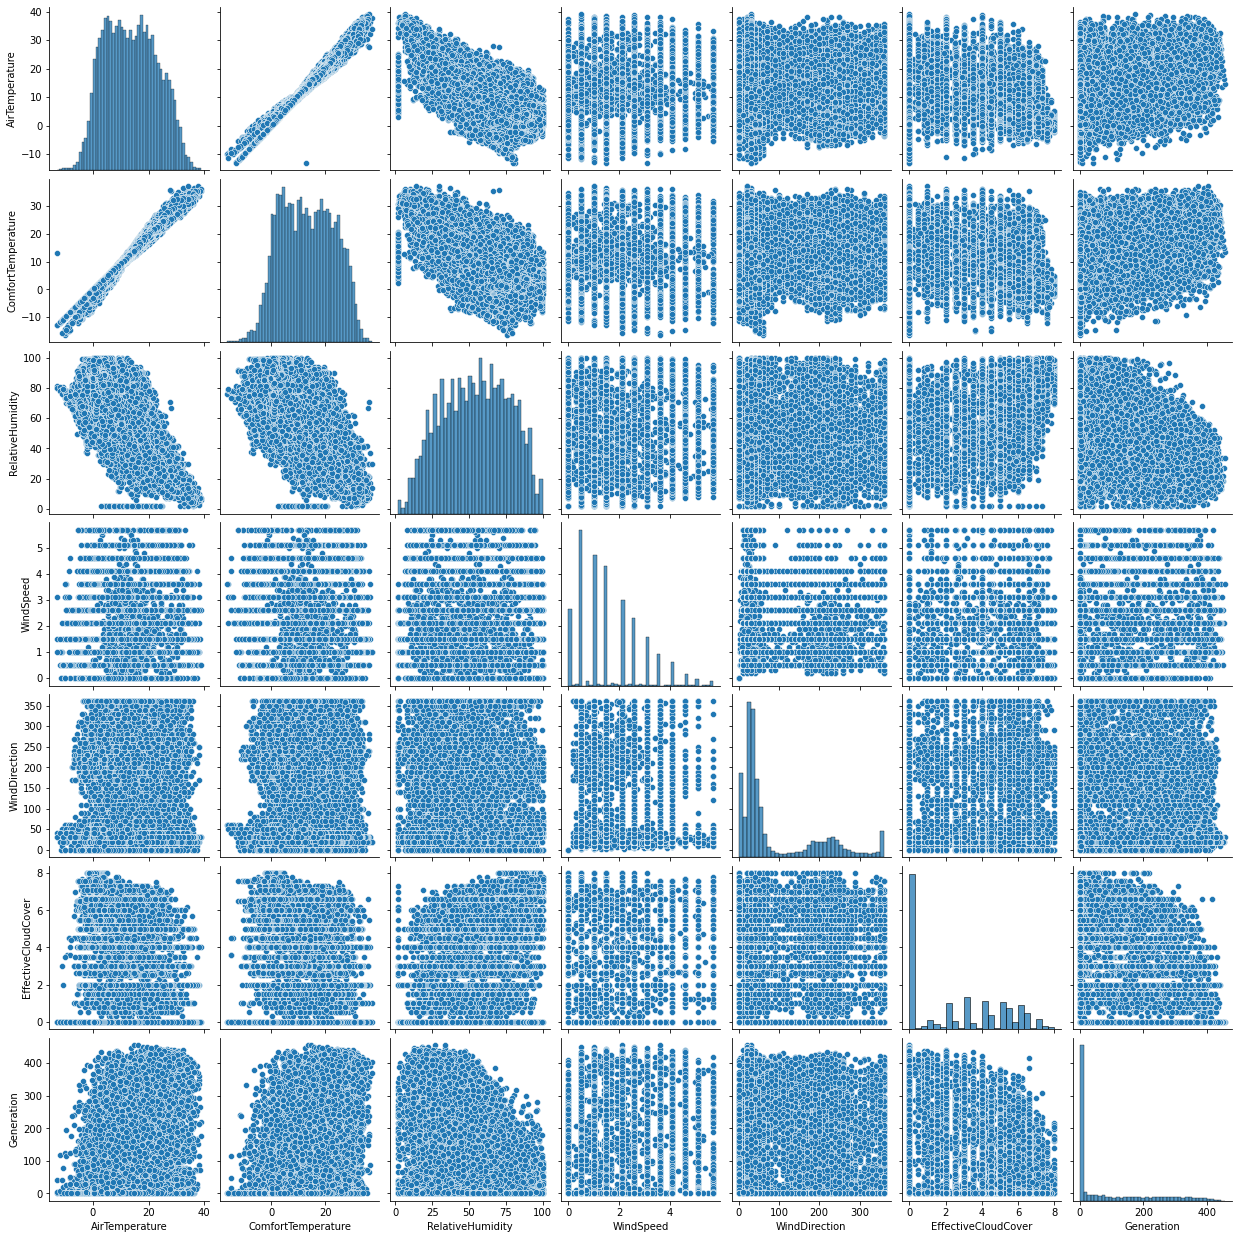

In [29]:
sns.pairplot(df[num_cols])

#### 1.6.2.3. Çarpıklık (Skewness)

*Çarpıklığı açıkla ve çözüm yolu bul!*

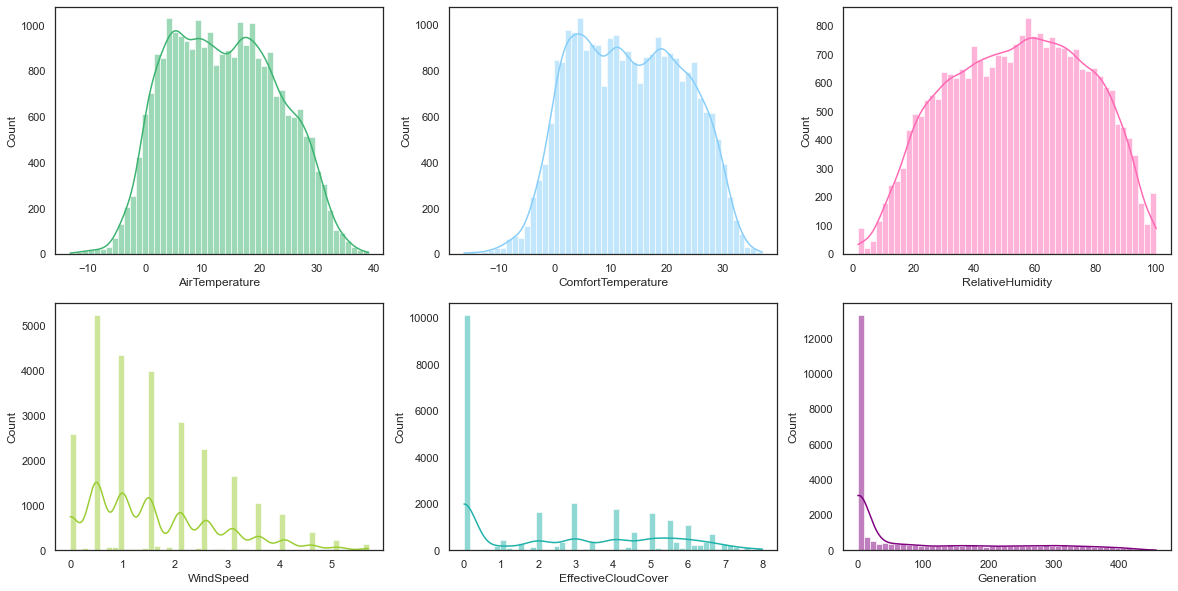

In [30]:
# set a grey background
sns.set(style="white")

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data = df, x = "AirTemperature",      kde = True, bins = 50, color = "mediumseagreen", ax = axs[0, 0])
sns.histplot(data = df, x = "ComfortTemperature",  kde = True, bins = 50, color = "lightskyblue",   ax = axs[0, 1])
sns.histplot(data = df, x = "RelativeHumidity",    kde = True, bins = 50, color = "hotpink",        ax = axs[0, 2])
sns.histplot(data = df, x = "WindSpeed",           kde = True, bins = 50, color = "yellowgreen",    ax = axs[1, 0])
sns.histplot(data = df, x = "EffectiveCloudCover", kde = True, bins = 50, color = "lightseagreen",  ax = axs[1, 1])
sns.histplot(data = df, x = "Generation",          kde = True, bins = 50, color = "purple",         ax = axs[1, 2])

plt.show()

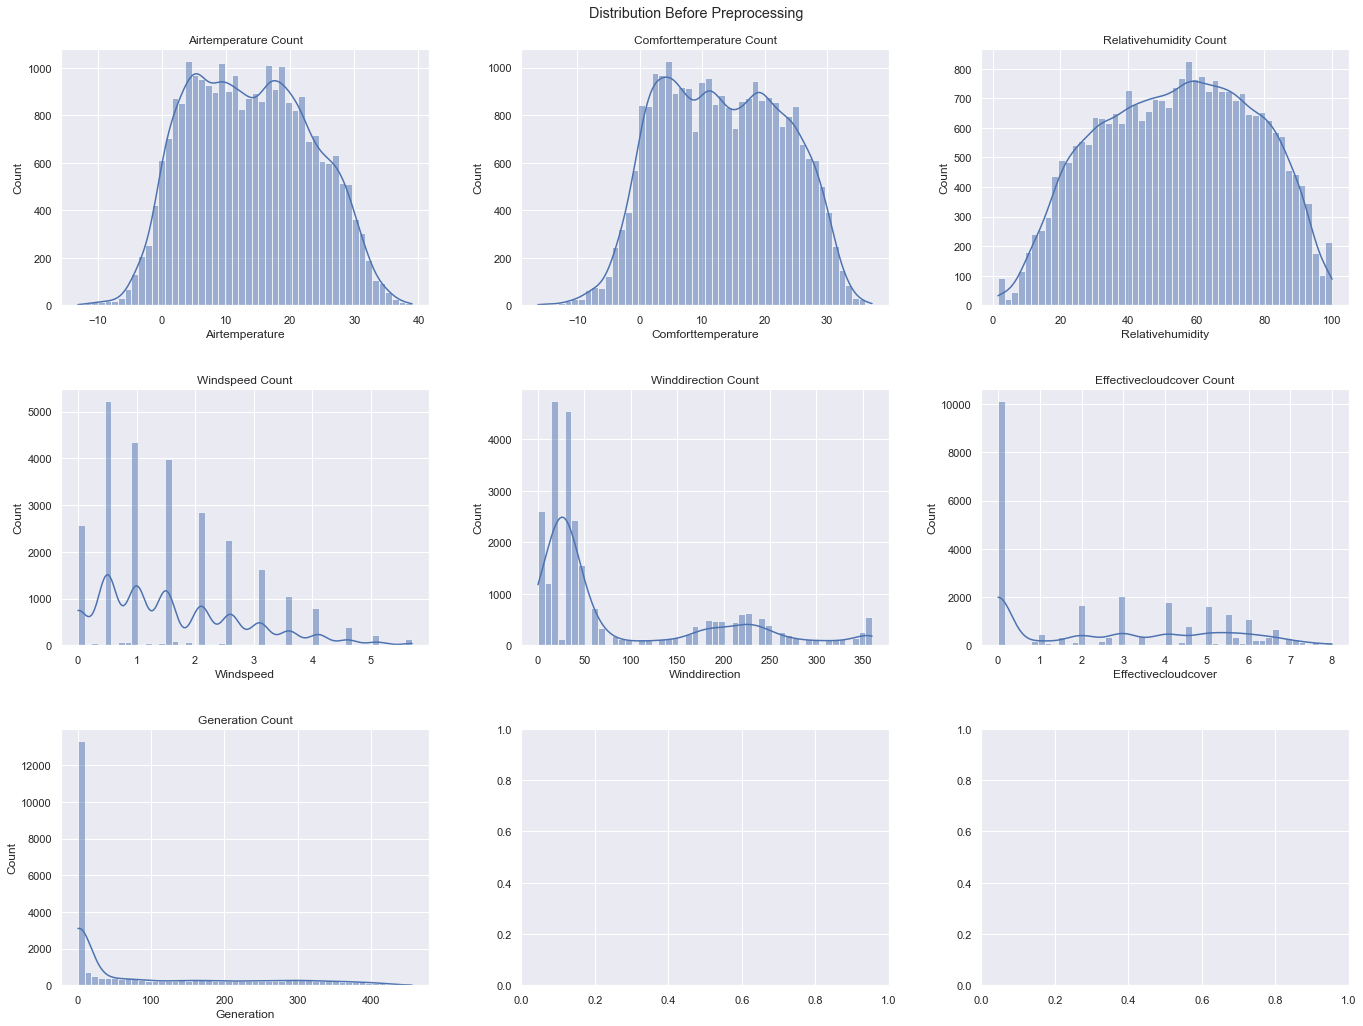

In [31]:
# set a grey background
sns.set(style="darkgrid")

f, axes = plt.subplots(3,3, figsize = (20,15))
f.tight_layout(pad=5)
f.suptitle("Distribution Before Preprocessing")
cols = df.select_dtypes(exclude=("object", "datetime64")).columns

x_axis = 0
y_axis = 0

for col in cols:
    sns.histplot(data = df, x = col, kde = True, bins = 50, ax = axes[x_axis, y_axis])
    axes[x_axis, y_axis].set_xlabel(col.title())
    axes[x_axis, y_axis].set_ylabel("Count")
    axes[x_axis, y_axis].set_title(f"{col.title()} Count")

    if y_axis == 2:
        y_axis = 0
        x_axis += 1
    else:
        y_axis += 1
                        
plt.show()

In [32]:
for i in num_cols:
    print ("Skew of", i, ":", df[i].skew())

Skew of AirTemperature : 0.12062466290022895
Skew of ComfortTemperature : 0.026752291811739753
Skew of RelativeHumidity : -0.08267005467248759
Skew of WindSpeed : 0.8433542510119664
Skew of WindDirection : 1.2532309122995284
Skew of EffectiveCloudCover : 0.32485029813084226
Skew of Generation : 1.1735449607940582


Skew -0.3126504524415186


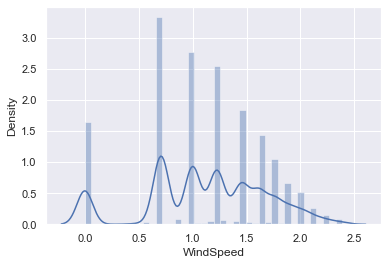

Skew -0.1403805438511943


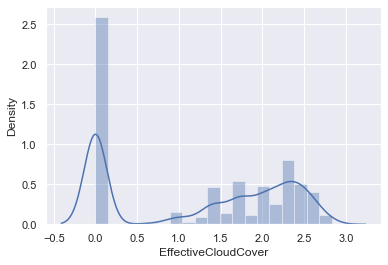

Skew 0.6476496317159635


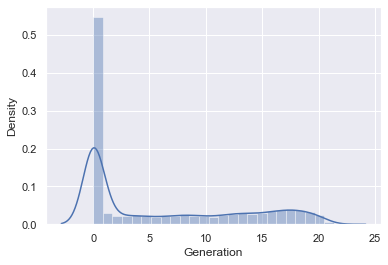

In [33]:
# Sağa çarpık verileri normal dağılıma yaklaştırmak için değerlerin karekökünü alma işlemi yapılması :

for i in ["WindSpeed", "EffectiveCloudCover", "Generation"]:
    df[i] = df[i]**(.5)
    print ("Skew", df[i].skew())
    sns.distplot(df[i])
    plt.show()

## 1.7. Time Series vs.
### 1.7.1. Yeni Column Oluşturma

In [34]:
df['dayofmonth'] = df.DateTime.dt.day
df['month']      = df.DateTime.dt.month
df['year']       = df.DateTime.dt.year
df['hour']       = df.DateTime.dt.hour
df['dayofweek']  = df.DateTime.dt.dayofweek
df['quarter']    = df.DateTime.dt.quarter
df['dayofyear']  = df.DateTime.dt.dayofyear
df['weekofyear'] = df.DateTime.dt.weekofyear

dayofmonth_grouping = df.groupby('dayofmonth').median()[['Generation']]
month_grouping      = df.groupby('month').median()[['Generation']]
year_grouping       = df.groupby('year').median()[['Generation']]
hour_grouping       = df.groupby('hour').median()[['Generation']]
dayofweek_grouping  = df.groupby('dayofweek').median()[['Generation']]
quarter_grouping    = df.groupby('quarter').median()[['Generation']]
dayofyear_grouping  = df.groupby('dayofyear').median()[['Generation']]
weekofyear_grouping = df.groupby('weekofyear').median()[['Generation']]

In [35]:
pd.concat([df['dayofmonth'],df['month'],df['year'],df['hour'],df['dayofweek'],df['quarter'],df['dayofyear'],df['weekofyear']], axis=1)

,dayofmonth,month,year,hour,dayofweek,quarter,dayofyear,weekofyear
0,1,1,2019,0,1,1,1,1
1,1,1,2019,1,1,1,1,1
2,1,1,2019,2,1,1,1,1
3,1,1,2019,3,1,1,1,1
4,1,1,2019,4,1,1,1,1
...,...,...,...,...,...,...,...,...
26299,31,12,2021,19,4,4,365,52
26300,31,12,2021,20,4,4,365,52
26301,31,12,2021,21,4,4,365,52
26302,31,12,2021,22,4,4,365,52


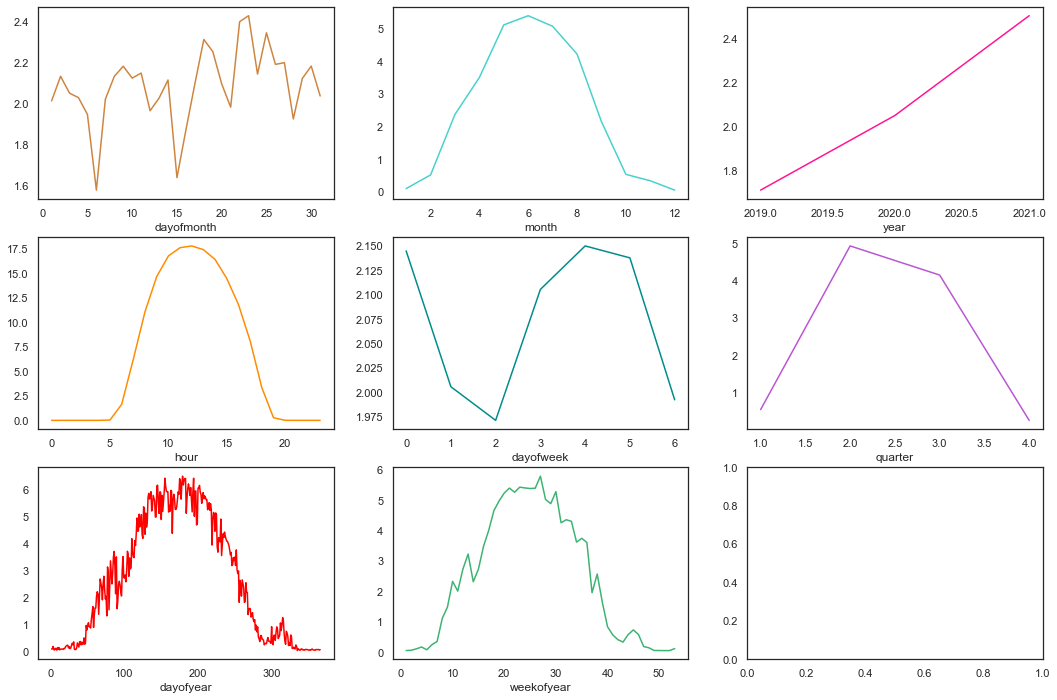

In [36]:
sns.set(style="white")

fig, axs = plt.subplots(3, 3, figsize=(18, 12))

dayofmonth_grouping["Generation"].plot(x = df.dayofmonth, color = "peru",            ax = axs[0, 0])
month_grouping["Generation"].plot(x = df.month,           color = "mediumturquoise", ax = axs[0, 1])
year_grouping["Generation"].plot(x = df.year,             color = "deeppink",        ax = axs[0, 2])
hour_grouping["Generation"].plot(x = df.hour,             color = "darkorange",      ax = axs[1, 0])
dayofweek_grouping["Generation"].plot(x = df.dayofweek,   color = "darkcyan",        ax = axs[1, 1])
quarter_grouping["Generation"].plot(x = df.quarter,       color = "mediumorchid",    ax = axs[1, 2])
dayofyear_grouping["Generation"].plot(x = df.dayofyear,   color = "red",             ax = axs[2, 0])
weekofyear_grouping["Generation"].plot(x = df.weekofyear, color = "mediumseagreen",  ax = axs[2, 1])
        
plt.show()

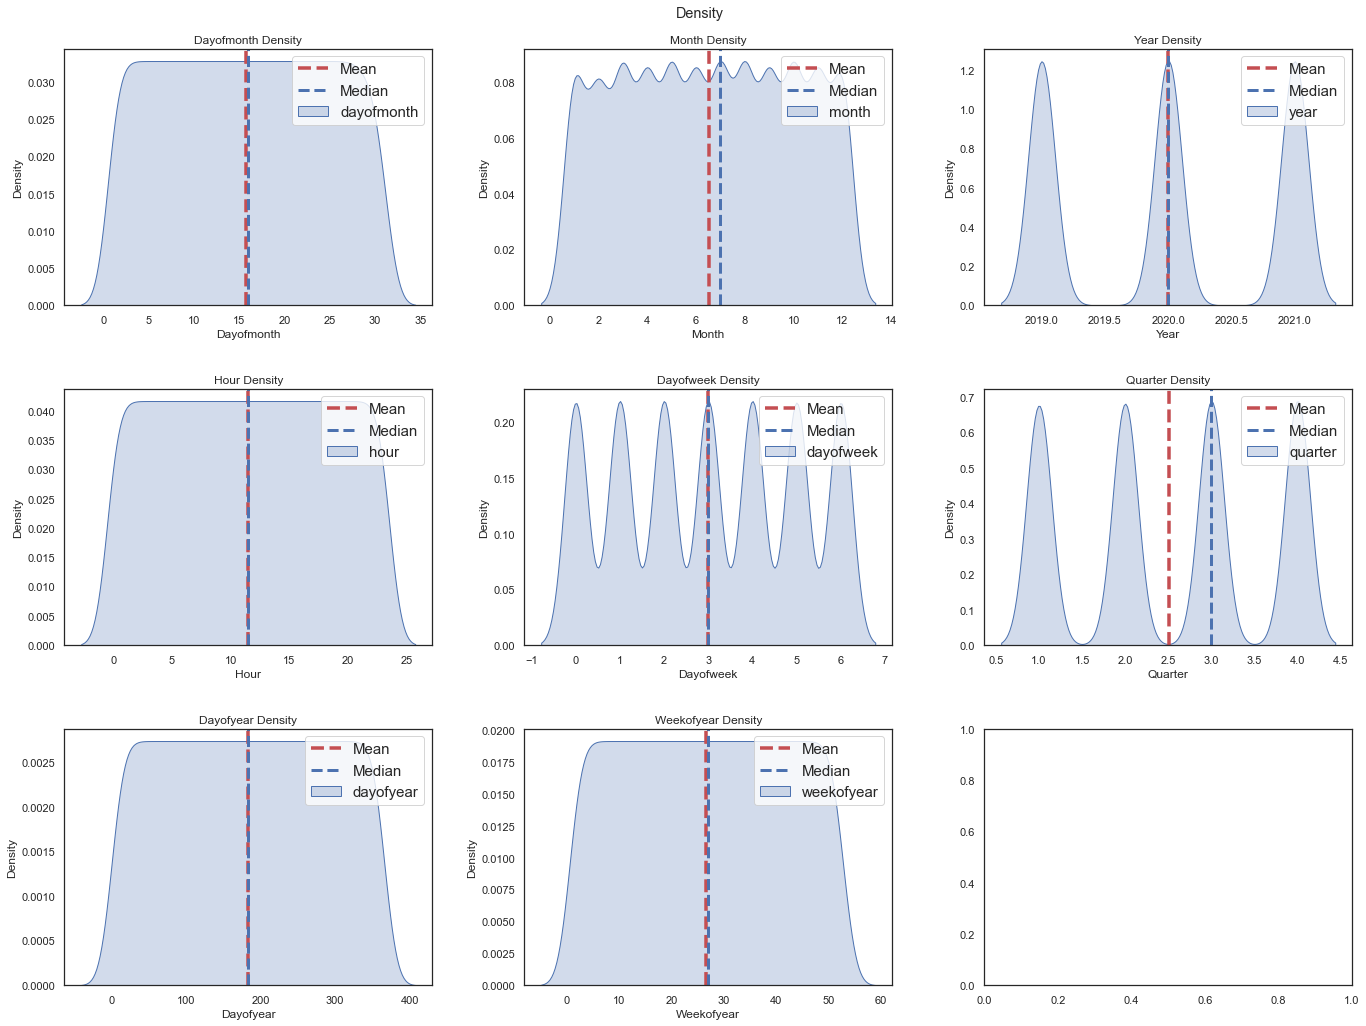

In [37]:
sns.set(style="white")

f, axes = plt.subplots(3,3, figsize = (20,15))
f.tight_layout(pad=5)
f.suptitle("Density")
cols = ['dayofmonth','month','year','hour','dayofweek','quarter','dayofyear','weekofyear']

x_axis = 0
y_axis = 0

for col in cols:
    sns.kdeplot(data = df, x = col, label = col, fill = True, ax = axes[x_axis, y_axis])
    axes[x_axis, y_axis].axvline(df[col].mean(), label = 'Mean', color = 'r', linewidth = 3.5, linestyle = '--')
    axes[x_axis, y_axis].axvline(df[col].median(), label = 'Median', color = 'b', linewidth = 3, linestyle = '--')
    axes[x_axis, y_axis].legend(prop = {'size': 15})
    axes[x_axis, y_axis].set_xlabel(col.title())
    axes[x_axis, y_axis].set_title(f"{col.title()} Density")

    if y_axis == 2:
        y_axis = 0
        x_axis += 1
    else:
        y_axis += 1
                        
plt.show()

- *'month'*, *'hour'*, *'quarter'*, *'dayofyear'*, *'weekofyear'* değişkenlerinin normal dağılım ya da normal dağılıma benzer bir dağılım gösterdiği gözlemlendi.

- *'month'*, *'hour'*, *'quarter'* değişkenlerinin '**object**' tipine dönüştürülmesi daha doğru olacağı düşünüldü.
- *'month'*, *'hour'*, *'quarter'* kolonları verisetinde kategorik veri olarak tutulacak.
- *'dayofmonth'*, *'year'*, *'dayofweek'*, *'dayofyear'*, *'weekofyear'* değişkenlerinin veri setinden çıkarılacak.

In [38]:
# 'month', hour' ve 'quarter' değişkenlerini int'ten object'e dönüştürme

df = df.astype({'month':'object', 'hour':'object', 'quarter':'object', 'dayofweek':'object'}) 

In [39]:
# veri setinden 'dayofmonth', 'year', 'dayofweek', 'dayofyear', 'weekofyear' değişkenlerinin çıkarılması: 

df = df.drop(['dayofmonth', 'year', 'dayofyear', 'weekofyear'], axis=1)

In [40]:
df.dtypes 

DateTime               datetime64[ns]
AirTemperature                float64
ComfortTemperature            float64
RelativeHumidity              float64
WindSpeed                     float64
WindDirection                 float64
WWCode                         object
EffectiveCloudCover           float64
Generation                    float64
month                          object
hour                           object
dayofweek                      object
quarter                        object
dtype: object

# 2. TRAIN & VALIDATION SPLIT

25560 tane verinin 20448 tanesi train, 5112 tanesi validation için ayrıldı. 

## 2.1. Train-Test-Validation Denemesi için

In [40]:
# Datetime kolonunun  verisetinden çıkarılması : 

df = df.drop(['DateTime'], axis = 1)

# train edilecek verisetinin ayrılması : 

df_train = df.iloc[:25560]

# 01.12.2021 – 31.12.2021 aralığındaki tahmin edilmesi istenen test verisetinin ayrılması :

df_val = df.iloc[25560:26304]

In [41]:
# validation verisetinin ayrılması : 

valData = df_train.tail(5112)
train_testData = df_train.head(20448)

##  2.2. İstenilen Tarih Aralığındaki Test Verisi için

In [ ]:
# Datetime kolonunun  verisetinden çıkarılması : 

df = df.drop(['DateTime'], axis = 1)

# train edilecek verisetinin ayrılması : 

train_testData = df.iloc[:25560]

# 01.12.2021 – 31.12.2021 aralığındaki tahmin edilmesi istenen test verisetinin ayrılması :

valData = df.iloc[25560:26304]

# 3. ONE-HOT-ENCODING & SCALING

## 3.1. Train Verisi

### 3.1.1. One-Hot-Encoding

In [42]:
cat_cols = [i for i in train_testData if train_testData[i].dtype == 'object']

for col in cat_cols:
    train_testData[col] = train_testData[col].astype('object')

columns_to_encode = []
for col in train_testData.columns:
    if train_testData[col].dtype == 'object':
        columns_to_encode.append(col)

oneHotEncoded_train_testData = pd.get_dummies(train_testData, columns = columns_to_encode)

### 3.1.2. Feature - Target Ayrımı

In [43]:
# Train verisi için ayırma işlemi

features = []
for col in oneHotEncoded_train_testData.columns:
    if col != 'Generation':
        features.append(col)

# Target - bağımlı değişken
target = 'Generation'

X = oneHotEncoded_train_testData[features]   # bağımsız değişkenler
y = oneHotEncoded_train_testData[target]   # target değişken

### 3.1.3. Standard Scaler

In [44]:
# X verisinin scale edilmesi :

sc = StandardScaler()
X = sc.fit_transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## 3.2. Validation Verisi

### 3.2.1. One-Hot-Encoding

In [46]:
col_list = oneHotEncoded_train_testData.columns.tolist()

cat_cols1 = [i for i in df if df[i].dtype == 'object']

for col in cat_cols1:
    valData[col] = valData[col].astype('object')

columns_to_encode1 = []
for col in valData.columns:
    if valData[col].dtype == 'object':
        columns_to_encode1.append(col)

oneHotEncoded_valData = pd.get_dummies(valData, columns = columns_to_encode1)

# reindex fonksiyonu kullanılarak iki veriseti arasındaki eksik kolonlar birbiri ile tamamlanması :

oneHotEncoded_valData = oneHotEncoded_valData.reindex(columns=col_list).fillna(0)

In [47]:
cols = oneHotEncoded_valData.columns
num_cols = oneHotEncoded_valData._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

### 3.2.2. Feature - Target Ayrımı

In [48]:
# Validation verisi için ayırma işlemi

features1 = []
for col in oneHotEncoded_valData.columns:
    if col != 'Generation':
        features1.append(col)

# Target - bağımlı değişken
target1 = 'Generation'

X_val = oneHotEncoded_valData[features1]   # bağımsız değişkenler
y_val = oneHotEncoded_valData[target1]   # target değişken

### 3.2.3. Standard Scaler

In [49]:
# X_val verisinin scale edilmesi :

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

# 4. MODELLEME & MODEL BAŞARI DEĞERLENDİRME

In [50]:
from warnings import filterwarnings
filterwarnings('ignore')

## 4.1. Linear Regression

In [51]:
# Modelin eğitilmesi 

from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train, y_train)

print("Linear Regression")
print(clf.predict(X_test))

Linear Regression
[ 11.50388542 117.08982292  -9.49611458 ... 257.26951042 175.44919792
  -8.00392708]


In [52]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, clf.predict(X_train)))   # eğitim hatası
rmse

47.14909749813115

In [53]:
rmse = np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))   # test hatası
rmse

47.62458663814523

In [54]:
rmse = np.sqrt(mean_squared_error(y_val, clf.predict(X_val)))   # validasyon hatası
rmse

33537113231210.145

## 4.2. PLS

In [55]:
# Modelin eğitilmesi 

from sklearn.cross_decomposition import PLSRegression, PLSSVD

pls_model = PLSRegression()
pls_model.fit(X_train, y_train)

print("Linear Regression")
print(pls_model.predict(X_test))

Linear Regression
[[ 28.38632195]
 [115.53276969]
 [  8.57999366]
 ...
 [274.74792598]
 [187.9532485 ]
 [-14.80203177]]


In [56]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, pls_model.predict(X_train)))   # eğitim hatası
rmse

51.38363637642372

In [57]:
rmse = np.sqrt(mean_squared_error(y_test, pls_model.predict(X_test)))   # test hatası
rmse

51.45394118114571

In [58]:
rmse = np.sqrt(mean_squared_error(y_val, pls_model.predict(X_val)))   # validasyon hatası
rmse

62.04355972614217

## 4.3. Ridge Regresyon

In [59]:
# Modelin eğitilmesi

from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

print("Ridge Regresyon")
print(ridge_model.predict(X_test))

Ridge Regresyon
[ 11.95984378 117.46914104  -9.3021886  ... 258.00604407 175.91088674
  -7.51337361]


In [60]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, ridge_model.predict(X_train)))   # eğitim hatası
rmse

47.14805783726227

In [61]:
rmse = np.sqrt(mean_squared_error(y_test, ridge_model.predict(X_test)))   # test hatası
rmse

47.63237828794535

In [62]:
rmse = np.sqrt(mean_squared_error(y_val, ridge_model.predict(X_val)))   # validasyon hatası
rmse

57.144706579639525

## 4.4. Lasso Regresyon

In [63]:
# Modelin eğitilmesi

from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

print("Ridge Regresyon")
print(lasso_model.predict(X_test))

Ridge Regresyon
[ 15.22549054 115.94504513  -7.0142221  ... 253.64600737 177.79396299
 -15.62235422]


In [64]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, lasso_model.predict(X_train)))   # eğitim hatası
rmse

47.60635072145728

In [65]:
rmse = np.sqrt(mean_squared_error(y_test, lasso_model.predict(X_test)))   # test hatası
rmse

47.985253082172704

In [66]:
rmse = np.sqrt(mean_squared_error(y_val, lasso_model.predict(X_val)))   # validasyon hatası
rmse

59.30807672752757

## 4.5. ElasticNet Regresyonu

In [67]:
# Modelin eğitilmesi

from sklearn.linear_model import ElasticNet

enet_model = ElasticNet()
enet_model.fit(X_train, y_train)

print("ElasticNet Regresyonu")
print(enet_model.predict(X_test))

ElasticNet Regresyonu
[ 45.16602403  92.36794116  29.99641371 ... 207.60944494 158.66759976
  10.21324083]


In [68]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, enet_model.predict(X_train)))   # eğitim hatası
rmse

58.84853205867167

In [69]:
rmse = np.sqrt(mean_squared_error(y_test, enet_model.predict(X_test)))   # test hatası
rmse

58.41976293221972

In [70]:
rmse = np.sqrt(mean_squared_error(y_val, enet_model.predict(X_val)))   # validasyon hatası
rmse

79.40379200049051

## 4.6. KNN

In [71]:
# Modelin eğitilmesi

from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

print("KNN")
print(knn_model.predict(X_test))

KNN
[6.29000000e-04 9.55984585e+01 1.98890520e-01 ... 3.11324072e+02
 2.17202613e+02 5.52496000e-02]


In [72]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, knn_model.predict(X_train)))   # eğitim hatası
rmse

29.43844413753628

In [73]:
rmse = np.sqrt(mean_squared_error(y_test, knn_model.predict(X_test)))   # test hatası
rmse

36.29792400299622

In [74]:
rmse = np.sqrt(mean_squared_error(y_val, knn_model.predict(X_val)))   # validasyon hatası
rmse

41.043992373170184

## 4.7. SVR (Destek Vektör Regresyonu)

In [75]:
# Modelin eğitilmesi

from sklearn.svm import SVR

svr_model = SVR()
svr_model.fit(X_train, y_train)

print("SVR")
print(svr_model.predict(X_test))

SVR
[  5.28027497  91.67058163   4.96427745 ... 169.71610399 126.9199681
   2.62217245]


In [76]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, svr_model.predict(X_train)))   # eğitim hatası
rmse

71.30957265387319

In [77]:
rmse = np.sqrt(mean_squared_error(y_test, svr_model.predict(X_test)))   # test hatası
rmse

69.92955216307064

In [78]:
rmse = np.sqrt(mean_squared_error(y_val, svr_model.predict(X_val)))   # validasyon hatası
rmse

92.41847346968964

## 4.8. Gradient Boosting Machines

In [79]:
# Modelin eğitilmesi

from sklearn.ensemble import GradientBoostingRegressor

gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

print("Gradient Boosting Machines")
print(gbm_model.predict(X_test))

Gradient Boosting Machines
[ 27.78641856  60.96305707   0.71515767 ... 231.23638171 133.84274852
   2.18876146]


In [80]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, gbm_model.predict(X_train)))   # eğitim hatası
rmse

33.72396385849375

In [81]:
rmse = np.sqrt(mean_squared_error(y_test, gbm_model.predict(X_test)))   # test hatası
rmse

35.10903044360444

In [82]:
rmse = np.sqrt(mean_squared_error(y_val, gbm_model.predict(X_val)))   # validasyon hatası
rmse

53.20200921824307

## 4.9. XGBoost

In [83]:
# Modelin eğitilmesi

import xgboost as xgb

DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)

from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

print("XGBoost")
print(xgb_model.predict(X_test))

XGBoost
[  5.932419   31.121376   -3.5427103 ... 184.07372   141.73122
  -0.5362166]


In [84]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train)))   # eğitim hatası
rmse

13.989329643095177

In [85]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))   # test hatası
rmse

24.50164297311622

In [86]:
rmse = np.sqrt(mean_squared_error(y_val, xgb_model.predict(X_val)))   # validasyon hatası
rmse

37.65723585732262

## 4.10. Light GBM

In [ ]:
# !pip install lightgbm

In [87]:
# Modelin eğitilmesi

from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm_model = lgbm.fit(X_train, y_train)

print("Light GBM")
print(lgbm_model.predict(X_test))

Light GBM
[  3.67506129  33.66897091   7.02666434 ... 199.43619222 168.18627858
  -3.55518938]


In [88]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, lgbm_model.predict(X_train)))   # eğitim hatası
rmse

20.275833345030776

In [89]:
rmse = np.sqrt(mean_squared_error(y_test, lgbm_model.predict(X_test)))   # test hatası
rmse

23.670833444369453

In [90]:
rmse = np.sqrt(mean_squared_error(y_val, lgbm_model.predict(X_val)))   # validasyon hatası
rmse

38.19769232352521

## 4.11. CatBoost

In [ ]:
# !pip install catboost

In [91]:
# Modelin eğitilmesi

from catboost import CatBoostRegressor

catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train)

print("Light GBM")
print(catb_model.predict(X_test))

Learning rate set to 0.063672
0:	learn: 115.9756237	total: 145ms	remaining: 2m 24s
1:	learn: 111.5582759	total: 157ms	remaining: 1m 18s
2:	learn: 107.4935132	total: 168ms	remaining: 56s
3:	learn: 103.8486666	total: 180ms	remaining: 44.9s
4:	learn: 100.5729512	total: 194ms	remaining: 38.6s
5:	learn: 97.3136196	total: 207ms	remaining: 34.3s
6:	learn: 94.5387223	total: 218ms	remaining: 30.9s
7:	learn: 91.8007432	total: 233ms	remaining: 28.9s
8:	learn: 89.3595774	total: 245ms	remaining: 26.9s
9:	learn: 86.9263708	total: 256ms	remaining: 25.3s
10:	learn: 84.9059237	total: 263ms	remaining: 23.7s
11:	learn: 82.7966979	total: 270ms	remaining: 22.2s
12:	learn: 80.8540673	total: 276ms	remaining: 20.9s
13:	learn: 79.0996296	total: 280ms	remaining: 19.7s
14:	learn: 77.5192599	total: 285ms	remaining: 18.7s
15:	learn: 76.1098738	total: 289ms	remaining: 17.8s
16:	learn: 74.5290998	total: 293ms	remaining: 16.9s
17:	learn: 72.9227050	total: 300ms	remaining: 16.4s
18:	learn: 71.6523538	total: 304ms	rema

In [92]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_train, catb_model.predict(X_train)))   # eğitim hatası
rmse

17.511058485524877

In [93]:
rmse = np.sqrt(mean_squared_error(y_test, catb_model.predict(X_test)))   # test hatası
rmse

22.79393768804774

In [94]:
rmse = np.sqrt(mean_squared_error(y_val, catb_model.predict(X_val)))   # validasyon hatası
rmse

36.84372005666025

# 5. KAYDETME

In [ ]:
data_predict  = pd.DataFrame(xgb_model.predict(X_val), columns = ['Generation'])
data_predict

In [ ]:
data_sample = pd.read_csv("sample_submission.csv", sep = ",", decimal = ",")
data_sample

In [ ]:
data = pd.concat([data_sample.drop('Generation', axis = 1), data_predict], axis = 1)
data

In [ ]:
import os  
os.makedirs('folder/subfolder', exist_ok=True)  
data.to_csv('folder/subfolder/xgb_model2.csv', index=False) 